In [ ]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime, date
plt.style.use('ggplot')

In [ ]:
trans=pd.read_csv('/content/Transactions_Cleaned.csv')
cust=pd.read_csv('/content/CustomerDemographic_Cleaned.csv')

In [ ]:
trans.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,Profit
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0,17.87
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0,1702.55
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0,1544.61
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0,817.36
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0,1055.82


In [ ]:
cust.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,Age
0,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0,67
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,Yes,16.0,40
2,3,Arlin,Dearle,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,N,Yes,15.0,67
3,4,Talbot,NaN,Male,33,1961-10-03,Missing,IT,Mass Customer,N,No,7.0,59
4,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,Missing,Affluent Customer,N,Yes,8.0,44


In [ ]:
print('Total number of records in Transaction:{}'.format(trans.shape[0]))
print('Total number of columns in Transaction:{}'.format(trans.shape[1]))

Total number of records in Transaction:19803
Total number of columns in Transaction:14


In [ ]:
print('Total number of records in Customer:{}'.format(cust.shape[0]))
print('Total number of columns in customer:{}'.format(cust.shape[1]))

Total number of records in Customer:3912
Total number of columns in customer:13


In [ ]:
merged_trans_cust=pd.merge(trans,cust,left_on='customer_id',right_on='customer_id',how ='inner')

In [ ]:
merged_trans_cust['wealth_segment'].value_counts()

wealth_segment
Mass Customer        9703
High Net Worth       4931
Affluent Customer    4720
Name: count, dtype: int64

In [ ]:
merged_trans_cust['transaction_date']=pd.to_datetime(merged_trans_cust['transaction_date'])

In [ ]:
max_trans_date=max(merged_trans_cust['transaction_date']).date()
max_trans_date

datetime.date(2017, 12, 30)

In [ ]:
comparison_date = datetime.strptime(str(max_trans_date), "%Y-%m-%d")

In [ ]:
rfm_table=merged_trans_cust.groupby(['customer_id']).agg({'transaction_date':lambda date :(comparison_date - date.max()).days,
                                                          'product_id':lambda prod_id: len(prod_id),
                                                          'Profit' :lambda p:sum(p)})

In [ ]:
print(rfm_table)

             transaction_date  product_id   Profit
customer_id                                       
1                           7          11  3018.09
2                         128           3  2226.26
3                         102           8  3362.81
4                         195           2   220.57
5                          16           6  2394.94
...                       ...         ...      ...
3496                      256           4  2045.84
3497                       52           3  1648.32
3498                      127           6  3147.33
3499                       51           7  4955.25
3500                      144           6  1785.86

[3416 rows x 3 columns]


In [ ]:
rfm_table.rename(columns ={'transaction_date':'recency',
                           'product_id':'frequency',
                           'Profit':'monetory'},inplace=True)

In [ ]:
rfm_table.columns

Index(['recency', 'frequency', 'monetory'], dtype='object')

In [ ]:
rfm_table['r_quartile']=pd.qcut(rfm_table['recency'],4,['4','3','2','1'])
rfm_table['f_quartile']=pd.qcut(rfm_table['frequency'],4,['4','3','2','1'])
rfm_table['m_quartile']=pd.qcut(rfm_table['monetory'],4,['4','3','2','1'])
rfm_table.dropna(axis=0,inplace=True)

In [ ]:
rfm_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3416 entries, 1 to 3500
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   recency     3416 non-null   int64   
 1   frequency   3416 non-null   int64   
 2   monetory    3416 non-null   float64 
 3   r_quartile  3416 non-null   category
 4   f_quartile  3416 non-null   category
 5   m_quartile  3416 non-null   category
dtypes: category(3), float64(1), int64(2)
memory usage: 117.4 KB


In [ ]:
rfm_table['rfm_score']=(100*rfm_table['r_quartile'].astype(int))+(10*rfm_table['f_quartile'].astype(int))+(rfm_table['m_quartile'].astype(int))

In [ ]:
rfm_table['customer_title']=pd.qcut(rfm_table['rfm_score'],4,['Bronze','Silver','Gold','Platinum'])

In [ ]:
cust_trans_rfm=pd.merge(merged_trans_cust,rfm_table,left_on='customer_id',right_on='customer_id',how ='inner')

In [ ]:
cust_trans_rfm['Age_Group']=cust_trans_rfm['Age'].apply(lambda x : (math.floor(x/10)+1)*10)

In [ ]:
def cust_score_title_lkup(cols):
  rfm_score = cols[0]
  if rfm_score>=444:
    return 'Platinum Customer'
  elif rfm_score>=433 and rfm_score<444:
    return 'Very Loyal'
  elif rfm_score>=421 and rfm_score<433:
    return 'Becoming Loyal'
  elif rfm_score>=344 and rfm_score<421:
    return 'Recent Customer'
  elif rfm_score>=323 and rfm_score<344:
    return 'Potentiel Customer'
  elif rfm_score>=421 and rfm_score<433:
    return 'Late Bloomer'
  elif rfm_score>=421 and rfm_score<433:
    return 'Loosing Customer'
  elif rfm_score>=421 and rfm_score<433:
    return 'High Risk Customer'
  elif rfm_score>=421 and rfm_score<433:
    return 'Almost Lost Customer'
  elif rfm_score>=421 and rfm_score<433:
    return 'Evasive Customer'
  else:
    return 'Lost Customer'


In [ ]:
cust_trans_rfm['detail_cust_title']=cust_trans_rfm[['rfm_score']].apply(cust_score_title_lkup,axis=1)

In [ ]:
cust_trans_rfm['detail_cust_title'].value_counts()


detail_cust_title
Lost Customer         11354
Recent Customer        2620
Potentiel Customer     2081
Becoming Loyal         1749
Very Loyal             1257
Platinum Customer       293
Name: count, dtype: int64

In [ ]:
cust_trans_rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19354 entries, 0 to 19353
Data columns (total 36 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   transaction_id                       19354 non-null  int64         
 1   product_id                           19354 non-null  int64         
 2   customer_id                          19354 non-null  int64         
 3   transaction_date                     19354 non-null  datetime64[ns]
 4   online_order                         19354 non-null  float64       
 5   order_status                         19354 non-null  object        
 6   brand                                19354 non-null  object        
 7   product_line                         19354 non-null  object        
 8   product_class                        19354 non-null  object        
 9   product_size                         19354 non-null  object        
 10  list_price

In [ ]:
new_cust=pd.read_csv('/content/NewCustomerList_Cleaned.csv')

<ipython-input-29-53a5247aa8f0>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_cust['Age Group'],kde =False,bins=15)


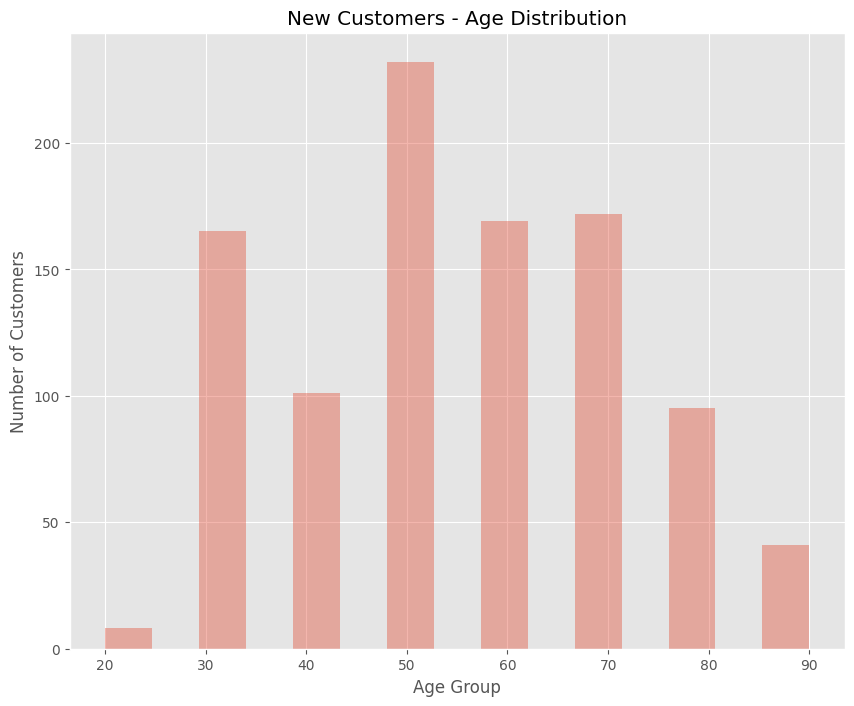

In [ ]:
plt.figure(figsize=(10,8))
sns.distplot(new_cust['Age Group'],kde =False,bins=15)
plt.xlabel('Age Group')
plt.ylabel('Number of Customers')
plt.title('New Customers - Age Distribution')
plt.show()

<ipython-input-30-9d8f2ad48cfe>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(cust_trans_rfm['Age_Group'], kde=False, bins=15)


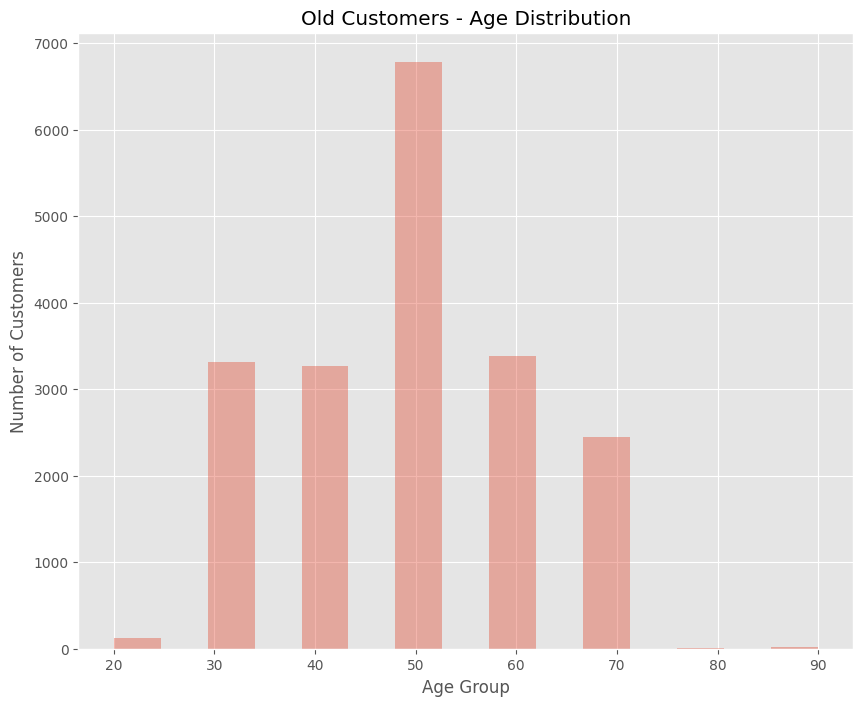

In [ ]:
plt.figure(figsize=(10,8))
sns.distplot(cust_trans_rfm['Age_Group'], kde=False, bins=15)
plt.xlabel('Age Group')
plt.ylabel('Number of Customers')
plt.title('Old Customers - Age Distribution')

plt.show()

In [ ]:
cust_bike_purchase_by_gender=cust_trans_rfm.groupby('gender').agg({'past_3_years_bike_related_purchases' : sum}).reset_index()

In [ ]:
print(cust_bike_purchase_by_gender)

   gender  past_3_years_bike_related_purchases
0  Female                               478488
1    Male                               468943


In [ ]:
total_records = cust_trans_rfm['past_3_years_bike_related_purchases'].sum()

In [ ]:
cust_bike_purchase_by_gender['Percent_of_total'] = (cust_bike_purchase_by_gender['past_3_years_bike_related_purchases']/total_records)*100

In [ ]:
cust_bike_purchase_by_gender

,gender,past_3_years_bike_related_purchases,Percent_of_total
0,Female,478488,50.503731
1,Male,468943,49.496269


## **3.2. Bike related purchases over last 3 years by gender**

Text(0.5, 1.0, 'Bike_Purchased_past_3_years_based_on_gender')

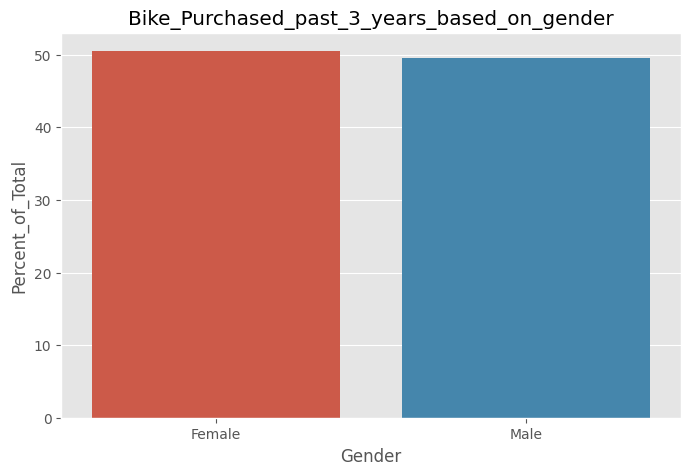

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x='gender',y='Percent_of_total',data=cust_bike_purchase_by_gender,hue='gender')
plt.xlabel('Gender')
plt.ylabel('Percent_of_Total')
plt.title('Bike_Purchased_past_3_years_based_on_gender')

## **3.3 Job Industry Customer Distribution**

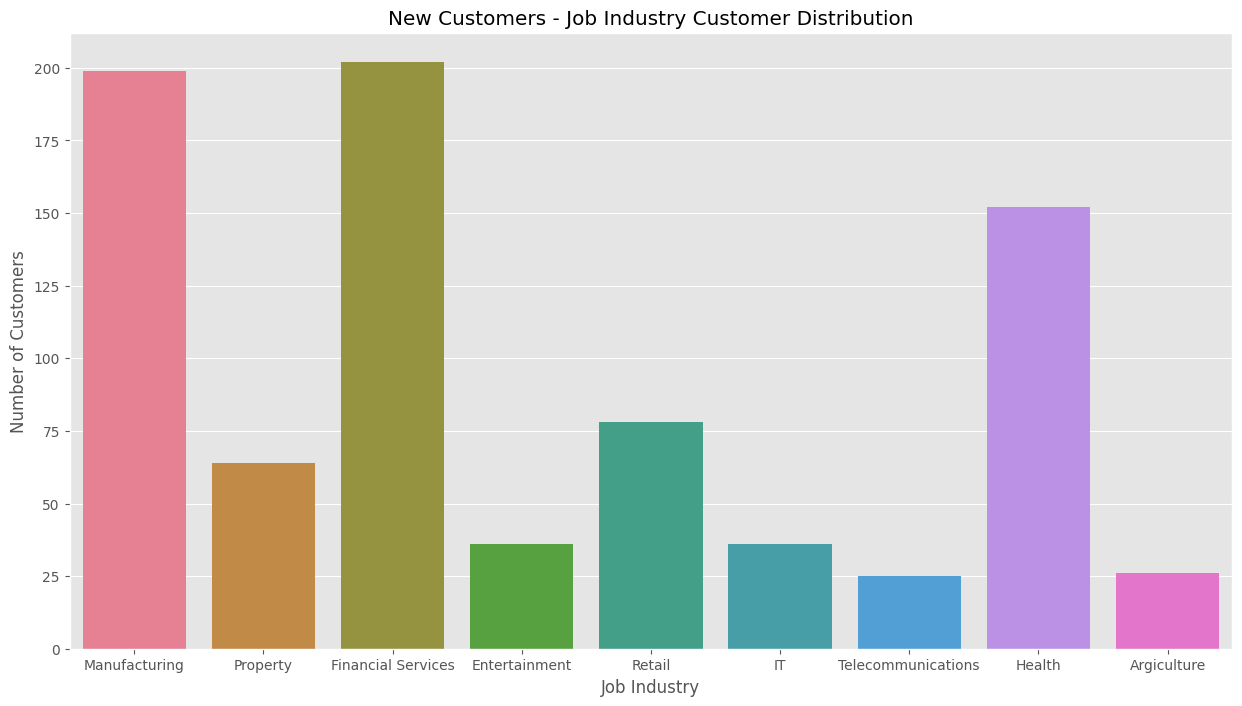

In [ ]:
plt.figure(figsize=(15,8))
sns.countplot(x='job_industry_category',hue='job_industry_category',data=new_cust[~(new_cust['job_industry_category']=='Missing')])
plt.xlabel('Job Industry')
plt.ylabel('Number of Customers')
plt.title('New Customers - Job Industry Customer Distribution')
plt.show()

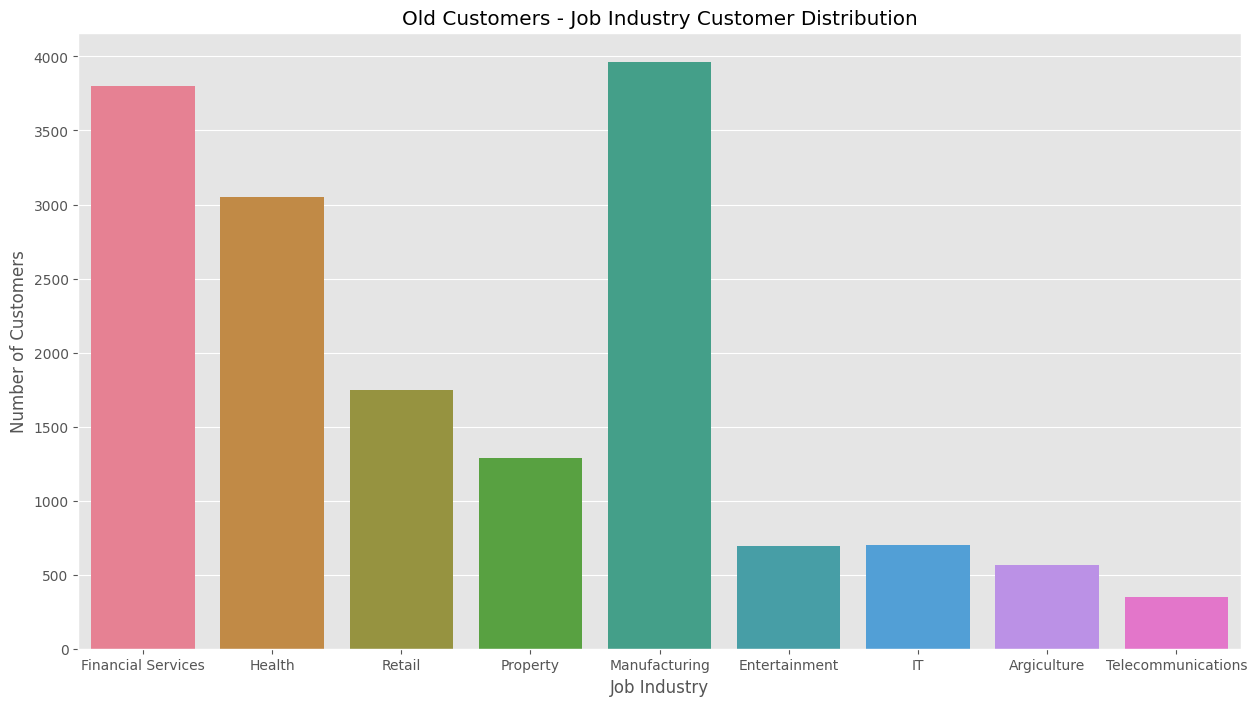

In [ ]:
plt.figure(figsize=(15,8))
sns.countplot(x='job_industry_category',hue='job_industry_category',data=cust_trans_rfm[~(cust_trans_rfm['job_industry_category']=='Missing')])
plt.xlabel('Job Industry')
plt.ylabel('Number of Customers')
plt.title('Old Customers - Job Industry Customer Distribution')
plt.show()

# **3.4. Wealth Segmentation by Age Group**

## **3.4.1 Wealth Segmentation by Age old Customer**

In [ ]:
wealth_age_seg_age_old=cust_trans_rfm.groupby(['wealth_segment','Age_Group']).size().reset_index()
wealth_age_seg_age_old.rename(columns={0:'Number_of_Customers'},inplace=True)
wealth_age_seg_age_old

,wealth_segment,Age_Group,Number_of_Customers
0,Affluent Customer,20,31
1,Affluent Customer,30,907
2,Affluent Customer,40,796
3,Affluent Customer,50,1577
4,Affluent Customer,60,833
5,Affluent Customer,70,561
6,Affluent Customer,80,5
7,Affluent Customer,90,10
8,High Net Worth,20,16
9,High Net Worth,30,800


In [ ]:
def get_rank(cols):

    title = cols[0]

    if title=='Platinum Customer':
        return 1
    elif title=='Very Loyal':
        return 2
    elif title == 'Becoming Loyal':
        return 3
    elif title == 'Recent Customer':
        return 4
    elif title=='Potential Customer':
        return 5
    elif title == 'Late Bloomer':
        return 6
    elif title == 'Loosing Customer':
        return 7
    elif title=='High Risk Customer':
        return 8
    elif title == 'Almost Lost Customer':
        return 9
    elif title == 'Evasive Customer':
        return 10
    else :
        return 11

cust_trans_rfm['rank']=cust_trans_rfm[['detail_cust_title']].apply(get_rank, axis=1)

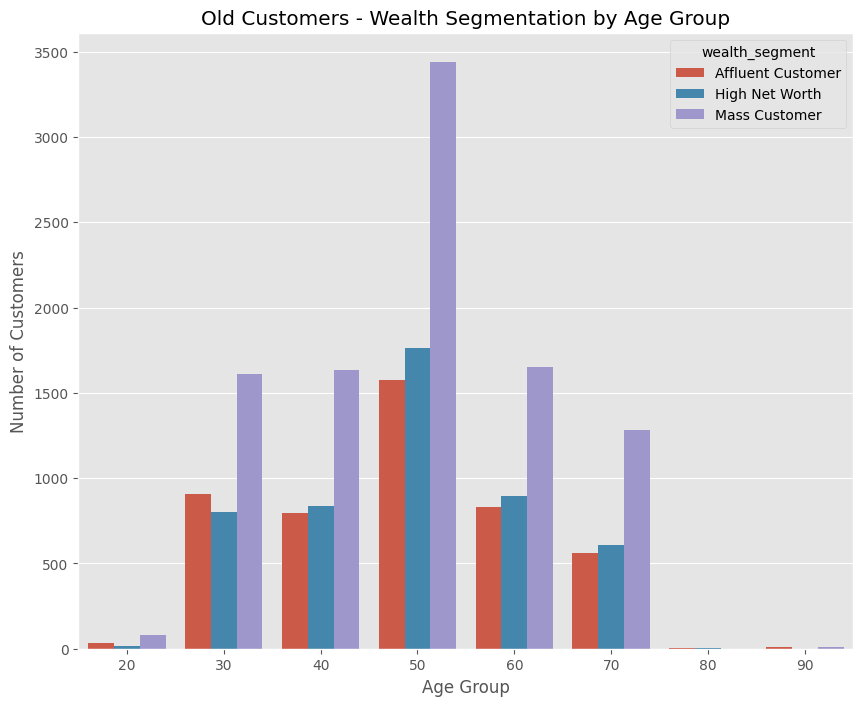

In [ ]:
plt.figure(figsize=(10,8))
sns.barplot(x='Age_Group',y='Number_of_Customers',hue='wealth_segment',data=wealth_age_seg_age_old)
plt.xlabel('Age Group')
plt.ylabel('Number of Customers')
plt.title('Old Customers - Wealth Segmentation by Age Group')
plt.show()

In [ ]:
wealth_age_seg_new = new_cust.groupby(['wealth_segment', 'Age Group']).size().reset_index()

In [ ]:
wealth_age_seg_new.rename(columns={0:'Number of Customers'}, inplace=True)
wealth_age_seg_new

,wealth_segment,Age Group,Number of Customers
0,Affluent Customer,20,3
1,Affluent Customer,30,49
2,Affluent Customer,40,15
3,Affluent Customer,50,58
4,Affluent Customer,60,40
5,Affluent Customer,70,41
6,Affluent Customer,80,20
7,Affluent Customer,90,9
8,High Net Worth,30,42
9,High Net Worth,40,34


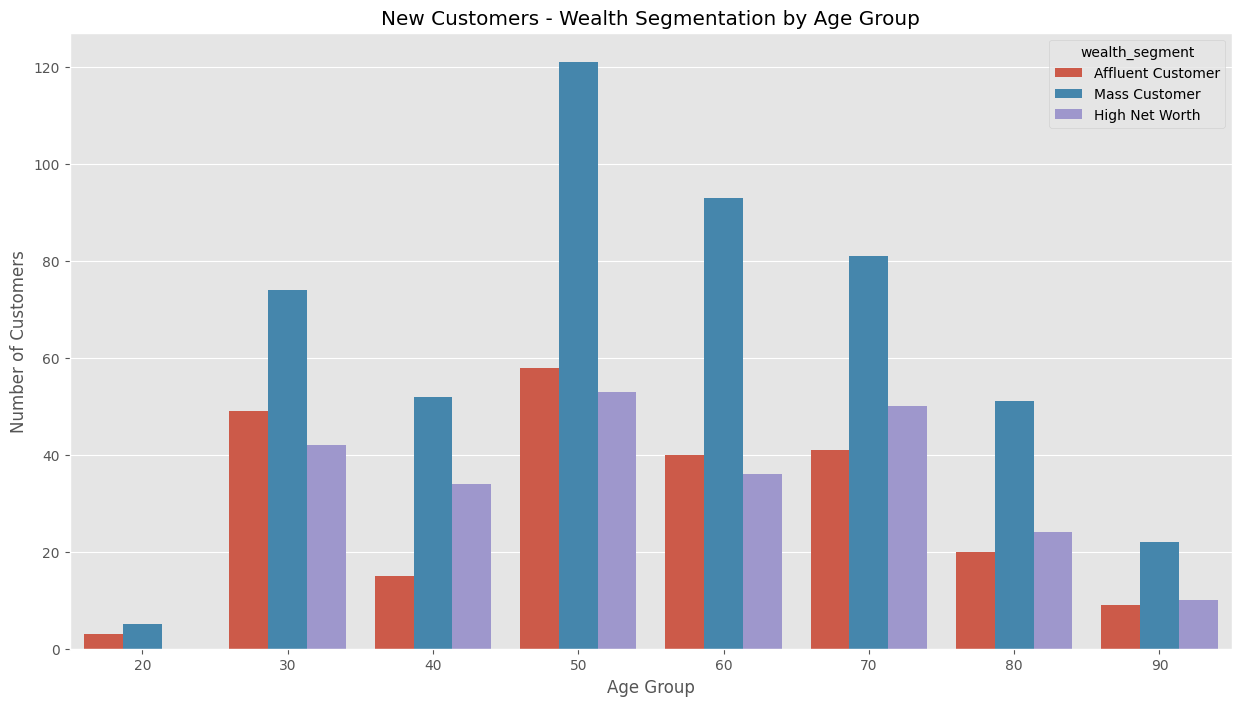

In [ ]:
plt.figure(figsize=(15,8))
sns.barplot(x='Age Group', y='Number of Customers' , hue='wealth_segment', data=wealth_age_seg_new)
plt.xlabel('Age Group')
plt.ylabel('Number of Customers')
plt.title('New Customers - Wealth Segmentation by Age Group')
plt.show()

## **3.5. Car owner across each State**

In [ ]:
cust_addr_info=pd.read_csv('/content/CustomerAddress_Cleaned.csv')

In [ ]:
cust_trans_addr=pd.merge(cust_trans_rfm,cust_addr_info,left_on='customer_id',right_on='customer_id',how='inner')

In [ ]:
print("RFM table Records count : {}\nAddress Table Records count :{}".format(cust_trans_rfm.shape[0] ,cust_addr_info.shape[0]))


RFM table Records count : 19354
Address Table Records count :3999


In [ ]:
cust_trans_addr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19327 entries, 0 to 19326
Data columns (total 42 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   transaction_id                       19327 non-null  int64         
 1   product_id                           19327 non-null  int64         
 2   customer_id                          19327 non-null  int64         
 3   transaction_date                     19327 non-null  datetime64[ns]
 4   online_order                         19327 non-null  float64       
 5   order_status                         19327 non-null  object        
 6   brand                                19327 non-null  object        
 7   product_line                         19327 non-null  object        
 8   product_class                        19327 non-null  object        
 9   product_size                         19327 non-null  object        
 10  list_price

In [ ]:
state_car_owners=cust_trans_addr[['state','owns_car','customer_id']].drop_duplicates().groupby(['state','owns_car']).size().reset_index()

In [ ]:
state_car_owners.rename(columns={0:'Number of Customers'}, inplace=True)
state_car_owners

,state,owns_car,Number of Customers
0,NSW,No,889
1,NSW,Yes,935
2,QLD,No,365
3,QLD,Yes,363
4,VIC,No,435
5,VIC,Yes,425


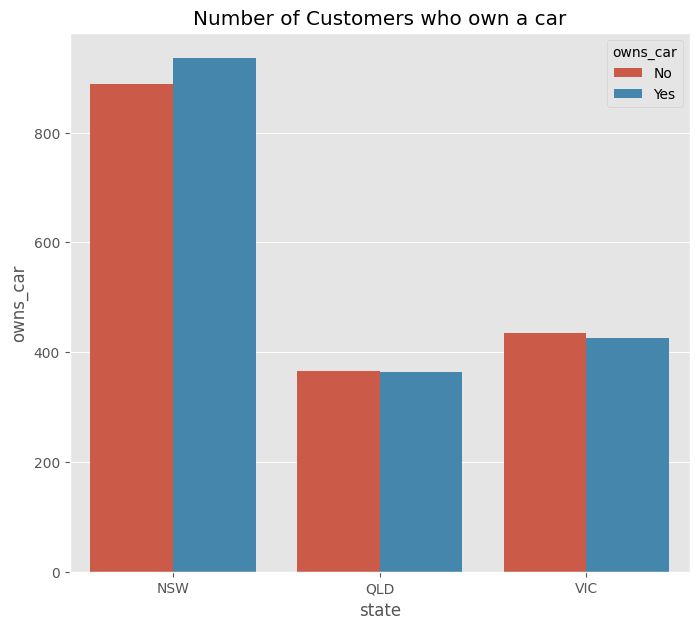

In [ ]:
plt.figure(figsize=(8,7))
sns.barplot(x='state',y='Number of Customers',hue='owns_car',data=state_car_owners)
plt.xlabel('state')
plt.ylabel('owns_car')
plt.title('Number of Customers who own a car')
plt.show()

In [ ]:
cust_trans_rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19354 entries, 0 to 19353
Data columns (total 37 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   transaction_id                       19354 non-null  int64         
 1   product_id                           19354 non-null  int64         
 2   customer_id                          19354 non-null  int64         
 3   transaction_date                     19354 non-null  datetime64[ns]
 4   online_order                         19354 non-null  float64       
 5   order_status                         19354 non-null  object        
 6   brand                                19354 non-null  object        
 7   product_line                         19354 non-null  object        
 8   product_class                        19354 non-null  object        
 9   product_size                         19354 non-null  object        
 10  list_price

## **RFM Analysis Scatter Plots**

<Figure size 800x500 with 0 Axes>

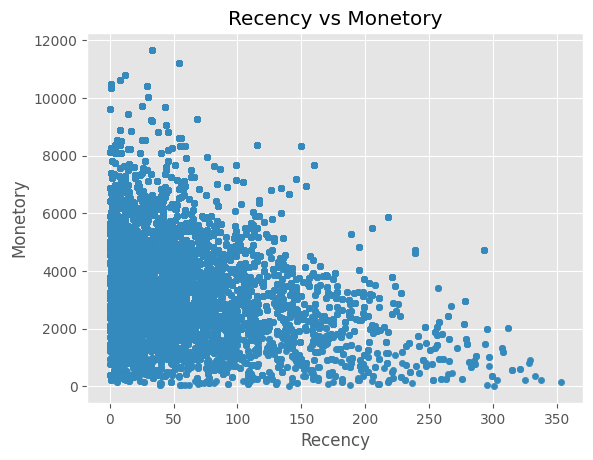

In [ ]:
plt.figure(figsize=(8,5))
cust_trans_rfm.plot.scatter(x='recency',y='monetory')
plt.xlabel('Recency')
plt.ylabel('Monetory')
plt.title('Recency vs Monetory')
plt.show()


<Figure size 800x500 with 0 Axes>

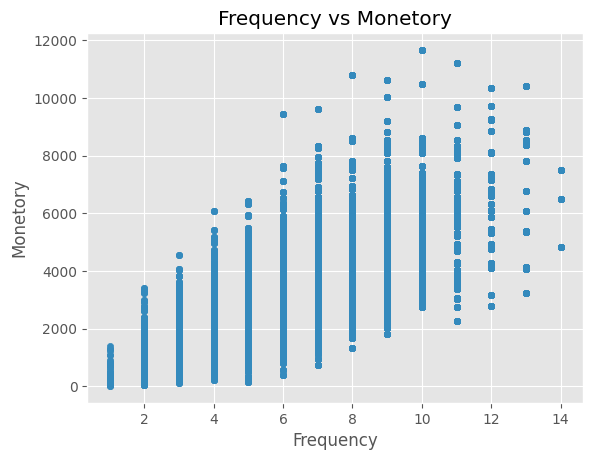

In [ ]:
plt.figure(figsize=(8,5))
cust_trans_rfm.plot.scatter(x='frequency',y='monetory')
plt.xlabel('Frequency')
plt.ylabel('Monetory')
plt.title('Frequency vs Monetory')
plt.show()